In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_tsv(input_file,columns):
    with open(input_file,"r",encoding="utf-8") as file:
        lines = []
        count = 1
        for line in file:
            if len(line.strip().split("\t")) != 1:
                lines.append([count]+line.strip().split("\t"))
                count += 1
        df = pd.DataFrame(lines)
        df.columns = columns
    return df

In [3]:
bq_train = read_tsv('data/bq_corpus/train.tsv',['index','sentences1','sentences2','label'])
bq_train.head()

,index,sentences1,sentences2,label
0,1,用微信都6年，微信没有微粒贷功能,4。号码来微粒贷,0
1,2,微信消费算吗,还有多少钱没还,0
2,3,交易密码忘记了找回密码绑定的手机卡也掉了,怎么最近安全老是要改密码呢好麻烦,0
3,4,你好我昨天晚上申请的没有打电话给我今天之内一定会打吗？,什么时候可以到账,0
4,5,"“微粒贷开通""",你好，我的微粒贷怎么没有开通呢,0


## 文本清洗
- 1、文本中的表情符号去除
- 2、将大写数字转化为小写数字
- 3、大写字母转化为小写字母
- 4、仅保留中文（这个未尝试）

In [4]:
#大写字母转为小写字母
def upper2lower(sentence):
    new_sentence=sentence.lower()
    return new_sentence
bq_train['chinese_sentences1'] = bq_train['sentences1'].apply(upper2lower)
bq_train['chinese_sentences2'] = bq_train['sentences2'].apply(upper2lower)

In [5]:
#去除文本中的表情字符（只保留中英文和数字）
import re
def clear_character(sentence):
    pattern1= '\[.*?\]'     
    pattern2 = re.compile('[^\u4e00-\u9fa5^a-z^A-Z^0-9]')   
    line1=re.sub(pattern1,'',sentence)
    line2=re.sub(pattern2,'',line1)   
    new_sentence=''.join(line2.split()) #去除空白
    return new_sentence
bq_train['chinese_sentences1'] = bq_train['chinese_sentences1'].apply(clear_character)
bq_train['chinese_sentences2'] = bq_train['chinese_sentences2'].apply(clear_character)

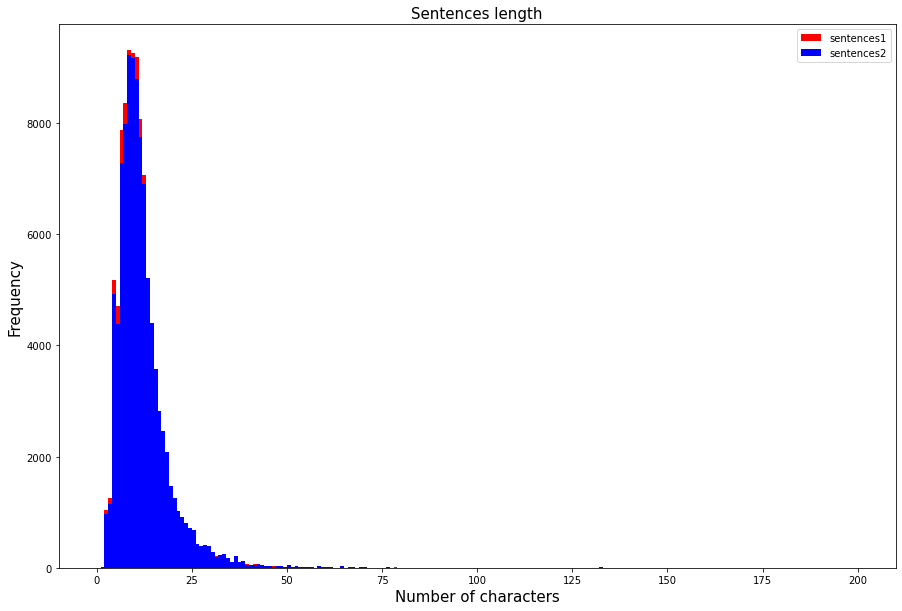

In [141]:
sentenses1 = pd.Series(bq_train['chinese_sentences1'].tolist()).astype(str)
sentences2 = pd.Series(bq_train['chinese_sentences2'].tolist()).astype(str)
dist1 = sentenses1.apply(len)
dist2 = sentences2.apply(len)
plt.figure(figsize=(15,10))
plt.hist(dist1, bins=200, range=[0,200], color='red', label='sentences1')
plt.hist(dist2, bins=200, range=[0,200], color='blue', label='sentences2')
plt.title('Sentences length', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

In [142]:
bq_train['sentences1_length'], bq_train['sentences2_length'] = pd.DataFrame(dist1), pd.DataFrame(dist2)

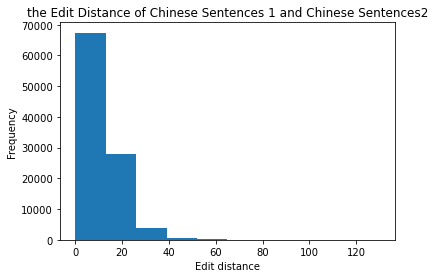

In [140]:
# Compute edit dostance
import distance

def edit_distance(s1, s2):
    return distance.levenshtein(s1, s2)

bq_train["edit_distance"] = bq_train.apply(lambda x: edit_distance(x["chinese_sentences1"], x["chinese_sentences2"]), axis=1)

plt.hist(bq_train['edit_distance'])
plt.xlabel("Edit distance")
plt.ylabel('Frequency')
plt.title('the Edit Distance of Chinese Sentences 1 and Chinese Sentences2')
plt.show();
#可见，sentence1和sentence2的编辑距离大部分落在1~20之间

In [143]:
bq_train

,index,sentences1,sentences2,label,chinese_sentences1,chinese_sentences2,edit_distance,jieba_sen1,jieba_sen2,sentences_inner,sentences1_length,sentences2_length,same_char_num,same_word_num
0,1,用微信都6年，微信没有微粒贷功能,4。号码来微粒贷,0,用微信都6年微信没有微粒贷功能,4号码来微粒贷,12,"用,微信,都,6,年,，,微信,没有,微粒,贷,功能","4,。,号码,来,微粒,贷",0.230069,15,7,3,8
1,2,微信消费算吗,还有多少钱没还,0,微信消费算吗,还有多少钱没还,7,"微信,消费,算,吗","还有,多少,钱,没,还",0.000000,6,7,0,3
2,3,交易密码忘记了找回密码绑定的手机卡也掉了,怎么最近安全老是要改密码呢好麻烦,0,交易密码忘记了找回密码绑定的手机卡也掉了,怎么最近安全老是要改密码呢好麻烦,19,"交易,密码,忘记,了,找回,密码,绑定,的,手机卡,也,掉,了","怎么,最近,安全,老是,要,改,密码,呢,好,麻烦",0.111299,20,16,2,11
3,4,你好我昨天晚上申请的没有打电话给我今天之内一定会打吗？,什么时候可以到账,0,你好我昨天晚上申请的没有打电话给我今天之内一定会打吗,什么时候可以到账,26,"你好,我,昨天晚上,申请,的,没有,打电话,给,我,今天,之内,一定,会,打,吗,？","什么,时候,可以,到,账",0.000000,26,8,0,4
4,5,"“微粒贷开通""",你好，我的微粒贷怎么没有开通呢,0,微粒贷开通,你好我的微粒贷怎么没有开通呢,9,"“,微粒,贷,开通,""","你好,，,我,的,微粒,贷,怎么,没有,开通,呢",0.335912,5,14,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,申请的额度能取现吗,取现一次性取完可以吗,0,申请的额度能取现吗,取现一次性取完可以吗,9,"申请,的,额度,能,取现,吗","取现,一次性,取完,可以,吗",0.245654,9,10,3,7
99996,99997,利息与罚息如何计算,咱这个利息多高啊,1,利息与罚息如何计算,咱这个利息多高啊,8,"利息,与,罚息,如何,计算","咱,这个,利息,多高,啊",0.196354,9,8,2,6
99997,99998,如何申请货款,怎样开通我微粒贷,1,如何申请货款,怎样开通我微粒贷,8,"如何,申请,货款","怎样,开通,我,微粒,贷",0.000000,6,8,0,2
99998,99999,多久才有贷款,凌晨以后的申请何时到账,1,多久才有贷款,凌晨以后的申请何时到账,11,"多久,才,有,贷款","凌晨,以后,的,申请,何时,到,账",0.000000,6,11,0,3


In [186]:
#使用jieba进行分词
import jieba
def word_segmentation(sentence):
    #分词函数
    return ' '.join([str(x) for x in jieba.cut(sentence)])

def numpy_df_iter(sentences):
    context_array = sentences.values        #转换为array，加快运算速度
    segment = []
    for sentence in context_array:
        segment.append(word_segmentation(sentence))
    return pd.DataFrame(segment)

bq_train['jieba_sen1'] = numpy_df_iter(bq_train['chinese_sentences1'])
bq_train['jieba_sen2'] = numpy_df_iter(bq_train['chinese_sentences2'])

In [146]:
#将两个句子转换为tfidf向量，并计算两个tfidf向量内积
from sklearn.feature_extraction.text import TfidfVectorizer
def sentences_tfidf_inner(sentences1, sentences2):
    length = sentenses1.shape[0]
    tfidf_segment1, tfidf_segment2, inner_sens= [], [], []
    for i in range(length):
        tfidf_sen12_vector = TfidfVectorizer(analyzer="char").fit_transform([sentences1[i], sentences2[i]]).toarray()
        tfidf_segment1.append(tfidf_sen12_vector[0])
        tfidf_segment2.append(tfidf_sen12_vector[1])
        inner_sens.append(np.inner(tfidf_sen12_vector[0], tfidf_sen12_vector[1]))
    return tfidf_segment1, tfidf_segment2, pd.DataFrame(inner_sens)

tfidf_sentences1, tfidf_sentences2, bq_train['sentences_inner']= sentences_tfidf_inner(bq_train['chinese_sentences1'], bq_train['chinese_sentences2'])

In [160]:
#计算共有字符chars/Word
from collections import Counter
#计算两个句子相同在字符个数
def count_sample_char(sentence1, sentence2, WORD=False):
    if WORD:
        #说明此时输入的是'jieba_sen_{1/2}'，要以','拆分成列表，再建词汇表。
        sentence1 = sentence1.split(',')
        sentence2 = sentence2.split(',')
    #构造两个句子的词汇表
    vocab1 = Counter(list(sentence1))
    vocab2 = Counter(list(sentence2))
    samekey_num = 0
    #判断keys()有没有相同的
    for key in vocab1.keys():
        if key in vocab2.keys():
            samekey_num += min(vocab1[key], vocab2[key])
        else:
            continue
    return samekey_num

In [164]:
def count_df_char(sentences1, sentences2, WORD=False):
    length = sentences1.shape[0]
    num_char = []
    for i in range(length):
        num_char.append(count_sample_char(sentences1[i], sentences2[i], WORD))
    return pd.DataFrame(num_char)
    
bq_train['same_char_num'] = count_df_char(bq_train['chinese_sentences1'], bq_train['chinese_sentences2'])

In [165]:
bq_train['same_word_num'] = count_df_char(bq_train['jieba_sen1'], bq_train['jieba_sen2'], WORD=True)

In [167]:
#句子A与句子B共有单词的个数 / 句子A字符个数
#句子A与句子B共有单词的个数 / 句子B字符个数
bq_train['sen1&sen2/sen1'] = bq_train['same_char_num']/bq_train['sentences1_length']
bq_train['sen1&sen2/sen2'] = bq_train['same_char_num']/bq_train['sentences2_length']

In [169]:
bq_train.head()

,index,sentences1,sentences2,label,chinese_sentences1,chinese_sentences2,edit_distance,jieba_sen1,jieba_sen2,sentences_inner,sentences1_length,sentences2_length,same_char_num,same_word_num,sen1&sen2/sen1,sen1&sen2/sen2
0,1,用微信都6年，微信没有微粒贷功能,4。号码来微粒贷,0,用微信都6年微信没有微粒贷功能,4号码来微粒贷,12,"用,微信,都,6,年,微信,没有,微粒,贷,功能","4,号码,来,微粒,贷",0.257064,15,7,3,2,0.2,0.428571
1,2,微信消费算吗,还有多少钱没还,0,微信消费算吗,还有多少钱没还,7,"微信,消费,算,吗","还有,多少,钱,没,还",0.000000,6,7,0,0,0.0,0.000000
2,3,交易密码忘记了找回密码绑定的手机卡也掉了,怎么最近安全老是要改密码呢好麻烦,0,交易密码忘记了找回密码绑定的手机卡也掉了,怎么最近安全老是要改密码呢好麻烦,19,"交易,密码,忘记,了,找回,密码,绑定,的,手机卡,也,掉,了","怎么,最近,安全,老是,要,改,密码,呢,好,麻烦",0.111299,20,16,2,1,0.1,0.125000
3,4,你好我昨天晚上申请的没有打电话给我今天之内一定会打吗？,什么时候可以到账,0,你好我昨天晚上申请的没有打电话给我今天之内一定会打吗,什么时候可以到账,26,"你好,我,昨天晚上,申请,的,没有,打电话,给,我,今天,之内,一定,会,打,吗","什么,时候,可以,到,账",0.000000,26,8,0,0,0.0,0.000000
4,5,"“微粒贷开通""",你好，我的微粒贷怎么没有开通呢,0,微粒贷开通,你好我的微粒贷怎么没有开通呢,9,"微粒,贷,开通","你好,我,的,微粒,贷,怎么,没有,开通,呢",0.468519,5,14,5,3,1.0,0.357143


In [174]:
#提取我们构造的特征
bq_data = bq_train[['sentences1_length', 'sentences2_length', 'edit_distance', 'sentences_inner', 'same_char_num', 'same_word_num', 'sen1&sen2/sen1', 'sen1&sen2/sen2']]
bq_target = bq_train['label']

In [182]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split as TTS
train_bq, test_bq, train_bq_y, test_bq_y = TTS(bq_data, bq_target, test_size=0.2, random_state=420)
train_bq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 67070 to 11185
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentences1_length  80000 non-null  int64  
 1   sentences2_length  80000 non-null  int64  
 2   edit_distance      80000 non-null  int64  
 3   sentences_inner    80000 non-null  float64
 4   same_char_num      80000 non-null  int64  
 5   same_word_num      80000 non-null  int64  
 6   sen1&sen2/sen1     80000 non-null  float64
 7   sen1&sen2/sen2     80000 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 5.5 MB


In [ ]:
#在这里尝试使用lightgbm二分类进行训练
import lightgbm as lgb
params_lgb ={
            'learning_rate':0.1, 
            'boosting_type':'gbdt',
            'objective':'binary',
            'nthread':4,
            'metric':'auc',
            'max_depth':5,
            'num_leaves': 30,
            'subsample':0.8,                # 数据采样
            'colsample_bytree': 0.8,        # 特征采样
}
lgb_train = lgb.Dataset(train_bq, train_bq_y)
cv_results = lgb.cv(params_lgb, lgb_train, num_boost_round=200, nfold=5, stratified=False, shuffle=True, metrics='auc', callbacks=[lgb.early_stopping(stopping_rounds=50)], seed=420)
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

In [217]:
list(bq_train['jieba_sen1'][0].split())

['用', '微信', '都', '6', '年', '微信', '没有', '微粒', '贷', '功能']

In [227]:
from gensim.models import word2vec
model = word2vec.Word2Vec(list(bq_train['jieba_sen1'][0].split()),hs=1,min_count=1,window=3)  

In [228]:
vector = model.wv['没有']  # get numpy vector of a word
vector

KeyError: "Key '没有' not present"